<a href="https://colab.research.google.com/github/Kottancheril/LLM/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install transformers and keras tuner
!pip install transformers tensorflow
!pip install keras-tuner

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
from keras_tuner.tuners import RandomSearch  # Updated import statement
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# pandas settings to view all rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




In [ ]:
!pip install datasets


In [ ]:
from datasets import load_dataset

# Load the Rotten Tomatoes dataset
dataset = load_dataset('rotten_tomatoes')

# Convert dataset to pandas DataFrame
def dataset_to_df(dataset):
    data = []
    for example in dataset:
        data.append({
            'text': example['text'],
            'label': example['label']
        })
    return pd.DataFrame(data)

# Convert train and test datasets to pandas DataFrames
train_df = dataset_to_df(dataset['train'])
test_df = dataset_to_df(dataset['test'])

# Split train_df into training and validation sets
train_df, val_df = train_test_split(train_df, random_state=123, test_size=0.2)

# Output shapes to verify
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Training DataFrame shape: (6824, 2)
Validation DataFrame shape: (1706, 2)
Test DataFrame shape: (1066, 2)


In [ ]:
# view sample of train_df
train_df.head(10)

,text,label
374,longley has constructed a remarkably coherent ...,1
1878,"the movie is hardly a masterpiece , but it doe...",1
6469,a bit of an unwieldy mess .,0
3952,an ambitious 'what if ? ' that works .,1
3596,horns and halos benefits from serendipity but ...,1
1777,i liked this film a lot . . .,1
11,what really surprises about wisegirls is its l...,1
6639,considering the harsh locations and demanding ...,0
2123,an amusing and unexpectedly insightful examina...,1
271,parker holds true to wilde's own vision of a p...,1


In [ ]:
# check for null data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6824 entries, 374 to 3582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6824 non-null   object
 1   label   6824 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 159.9+ KB


In [ ]:
# take acopy of train_df for eda
df = train_df.copy()
# count the label class into dictionary
label_count = df['label'].replace([0,1], ['Negative', 'Positive']).value_counts().to_dict()

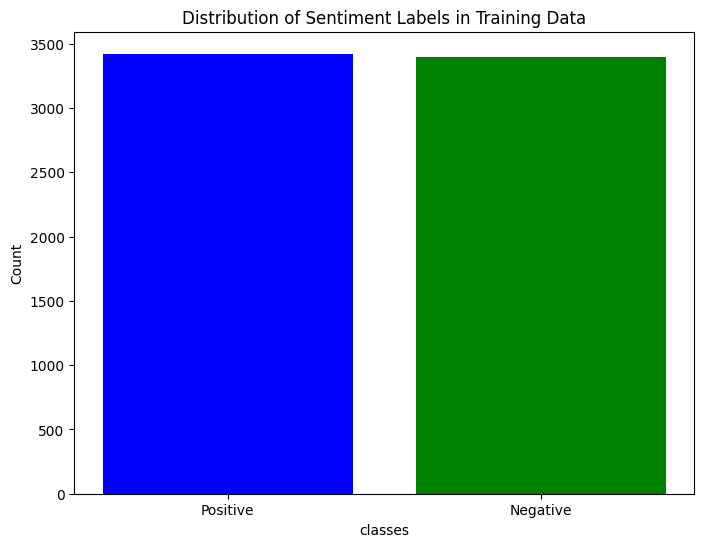

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart for label distribution
labels = list(label_count.keys())
counts = list(label_count.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('classes')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels in Training Data')
plt.show()


In [ ]:
df_positive = df[df['label'] == 1]
print('Positive Reviews:')

# Iterate through rows to print out text of sampled positive reviews
for _, row in df_positive.sample(5).iterrows():
    print(row['text'])
    print(' ')


Positive Reviews:
nair doesn't use [monsoon wedding] to lament the loss of culture . instead , she sees it as a chance to revitalize what is and always has been remarkable about clung-to traditions .
 
a fine film , but it would be a lot better if it stuck to betty fisher and left out the other stories .
 
it's a strange film , one that was hard for me to warm up to .
 
what it lacks in substance it makes up for in heart .
 
both flawed and delayed , martin scorcese's gangs of new york still emerges as his most vital work since goodfellas .
 


In [ ]:
df_negative = df[df['label'] == 0]
print('Negative Reviews:')

# Iterate through rows to print out text of sampled negative reviews
for _, row in df_negative.sample(5).iterrows():
    print(row['text'])
    print(' ')


Negative Reviews:
what is 100% missing here is a script of even the most elemental literacy , an inkling of genuine wit , and anything resembling acting .
 
i didn't find much fascination in the swinging . what they're doing is a matter of plumbing arrangements and mind games , of no erotic or sensuous charge . but that they are doing it is thought-provoking .
 
like so many other allegedly scary movies , it gets so tangled up in the twist that it chokes the energy right out of the very audience it seeks to frighten .
 
donovan . . . squanders his main asset , jackie chan , and fumbles the vital action sequences .
 
the next big thing's not-so-big ( and not-so-hot ) directorial debut .
 


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess(data):
    """
    Function that tokenizes the DataFrame and converts it into a TensorFlow dataset.

    Args:
    data (DataFrame): A pandas DataFrame with 'text' and 'label' columns.

    Returns:
    tf.data.Dataset: A TensorFlow dataset containing tokenized text and labels.
    """
    texts = data['text'].tolist()  # Convert text column to list
    labels = data['label'].tolist()  # Convert label column to list

    # Tokenize the text data
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

    # Create a TensorFlow dataset from the encodings and labels
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),  # Use the encodings dictionary (input_ids, attention_mask, etc.)
        labels  # Labels for the classification task
    ))

    return dataset


In [ ]:
train_dataset = preprocess(train_df).batch(16)
val_dataset = preprocess(val_df).batch(16)
test_dataset = preprocess(test_df).batch(16)


In [ ]:
def train_and_evaluate(learning_rate, epochs=2):
    """
    Train and evaluate BERT model with specified hyperparameters.

    Args:
    learning_rate (float): Learning rate for the optimizer.
    epochs (int): Number of training epochs.

    Returns:
    float: Validation accuracy.
    """
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=2
    )

    # Return the best validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

In [ ]:
# List of learning rates to test
learning_rates = [1e-5, 2e-5, 5e-5]

# Dictionary to store results
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    val_accuracy = train_and_evaluate(learning_rate=lr)
    results[lr] = val_accuracy
    print(f"Validation Accuracy: {val_accuracy}")

# Print the best learning rate
best_lr = max(results, key=results.get)
print(f"Best learning rate: {best_lr} with accuracy: {results[best_lr]}")


Training with learning rate: 1e-05


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
427/427 - 6618s - loss: 0.4282 - accuracy: 0.7995 - val_loss: 0.3366 - val_accuracy: 0.8552 - 6618s/epoch - 15s/step
Epoch 2/2
427/427 - 6567s - loss: 0.2546 - accuracy: 0.9050 - val_loss: 0.3949 - val_accuracy: 0.8488 - 6567s/epoch - 15s/step
Validation Accuracy: 0.8552168607711792
Training with learning rate: 2e-05


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
427/427 - 6652s - loss: 0.4522 - accuracy: 0.7710 - val_loss: 0.3883 - val_accuracy: 0.8464 - 6652s/epoch - 16s/step
Epoch 2/2
427/427 - 6603s - loss: 0.2145 - accuracy: 0.9172 - val_loss: 0.3840 - val_accuracy: 0.8605 - 6603s/epoch - 15s/step
Validation Accuracy: 0.8604924082756042
Training with learning rate: 5e-05


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
427/427 - 6703s - loss: 0.4353 - accuracy: 0.7962 - val_loss: 0.3839 - val_accuracy: 0.8470 - 6703s/epoch - 16s/step
Epoch 2/2
427/427 - 6655s - loss: 0.1986 - accuracy: 0.9213 - val_loss: 0.3636 - val_accuracy: 0.8411 - 6655s/epoch - 16s/step
Validation Accuracy: 0.8470105528831482
Best learning rate: 2e-05 with accuracy: 0.8604924082756042


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer

def evaluate_on_test_set(model, test_dataset):
    """
    Evaluate the model on the test dataset.

    Args:
    model (tf.keras.Model): The trained model.
    test_dataset (tf.data.Dataset): The test dataset.

    Returns:
    float: Test accuracy.
    """
    results = model.evaluate(test_dataset, verbose=2)
    return results[1]  # Returns the accuracy

# Retrain the model with the best learning rate
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)]
)

# Load the best model
model.load_weights('best_model.h5')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


427/427 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8129 
Epoch 1: val_loss improved from inf to 0.34971, saving model to best_model.h5


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [ ]:
# Evaluate on the test set
test_accuracy = evaluate_on_test_set(model, test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


67/67 - 268s - loss: 0.3980 - accuracy: 0.8368 - 268s/epoch - 4s/step
Test Accuracy: 0.8368


In [ ]:
def predict_sentiment(text, model, tokenizer):
    """
    Predict the sentiment of a given text using the trained model.

    Args:
    text (str): Input text for prediction.
    model (tf.keras.Model): The trained BERT model.
    tokenizer (BertTokenizer): The tokenizer for BERT.

    Returns:
    str: Predicted sentiment label ('Positive' or 'Negative').
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)

    # Make prediction
    logits = model(inputs)[0]

    # Get the predicted label (0 or 1)
    predicted_label = tf.argmax(logits, axis=1).numpy()[0]

    # Convert label to sentiment
    sentiment = 'Positive' if predicted_label == 1 else 'Negative'

    return sentiment



In [ ]:
sample_texts = [
    "The movie was fantastic! I really enjoyed it.",
    "It was a waste of time, I didn't like it at all.",
    "An amazing experience, totally worth it!",
    "The plot was dull and uninspiring."
]

for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


Text: The movie was fantastic! I really enjoyed it.
Predicted Sentiment: Positive

Text: It was a waste of time, I didn't like it at all.
Predicted Sentiment: Negative

Text: An amazing experience, totally worth it!
Predicted Sentiment: Positive

Text: The plot was dull and uninspiring.
Predicted Sentiment: Negative

